In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#loading the output
data0 = pd.read_csv('./out/out0.csv') #Z0.02
data1= pd.read_csv('./out/out1.csv') #Z0.00014

In [2]:
# adding a column with the mass ratio mass_BH / mass_WR
df0 = data0.copy()
mask = ~(df0['PhaseBSE_0']==14.0) #True where is not 14
df0.loc[mask, ['Mass_0', 'Mass_1']] = (df0.loc[mask, ['Mass_1', 'Mass_0']].values) 
df0 = df0.rename(columns={"Mass_0": "Mass_BH", "Mass_1": "Mass_WR"})
df0['Mass_ratio'] = df0['Mass_BH'] / df0['Mass_WR']

df1 = data1.copy()
mask = ~(df1['PhaseBSE_0']==14.0)
df1.loc[mask, ['Mass_0', 'Mass_1']] = (df1.loc[mask, ['Mass_1', 'Mass_0']].values)
df1 = df1.rename(columns={"Mass_0": "Mass_BH", "Mass_1": "Mass_WR"})
df1['Mass_ratio'] = df1['Mass_BH'] / df1['Mass_WR']

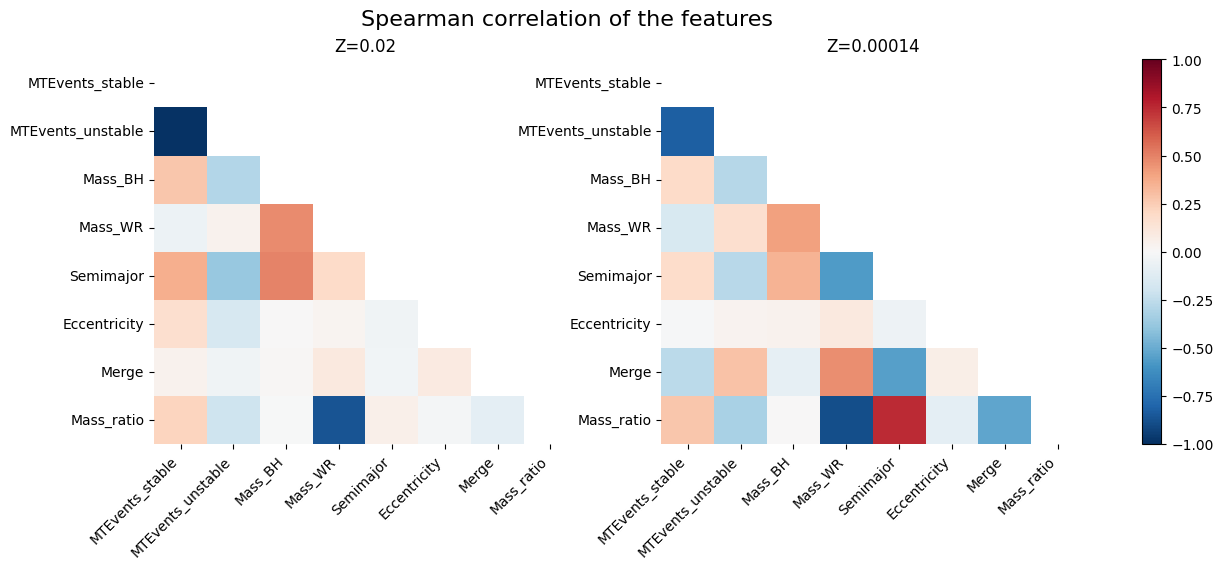

In [3]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
corr_matrix_0 = df0.iloc[:,[1,2,4,5,6,7,8,9]].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix_0, dtype=bool))
sns.heatmap(corr_matrix_0, mask=mask, cmap='RdBu_r', linecolor='w',ax=axs[0],vmin=-1, vmax=1,cbar=False)
axs[0].set_title('Z=0.02')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

corr_matrix_1 = df1.iloc[:,[1,2,4,5,6,7,8,9]].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix_1, dtype=bool))
sns.heatmap(corr_matrix_1, mask=mask, cmap='RdBu_r', linecolor='w',ax=axs[1],vmin=-1, vmax=1,cbar=False)
axs[1].set_title('Z=0.00014')
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
fig.colorbar(axs[0].collections[0], ax=axs)
fig.suptitle('Spearman correlation of the features',ha='center',fontsize=16,x=0.4)
plt.show()

In [4]:
df1

,ID,MTEvents_stable,MTEvents_unstable,PhaseBSE_0,Mass_BH,Mass_WR,Semimajor,Eccentricity,Merge,Mass_ratio
0,1728.0,1,0,14.0,25.407030,5.921796,130.361300,0.0,0,4.290426
1,32865.0,1,0,14.0,20.304470,6.703201,78.081990,0.0,0,3.029071
2,95208.0,1,0,14.0,27.861980,5.346332,287.187400,0.0,0,5.211420
3,146466.0,1,0,14.0,30.853290,31.023100,95.885890,0.0,0,0.994526
4,156581.0,1,0,14.0,43.214560,47.305600,161.307700,0.0,0,0.913519
...,...,...,...,...,...,...,...,...,...,...
107820,4052651.0,1,0,14.0,11.537990,7.900811,3.054249,0.0,0,1.460355
107821,4078939.0,1,0,14.0,28.015520,2.570577,717.376500,0.0,0,10.898534
107822,4085125.0,1,0,14.0,7.688564,1.304752,112.961300,0.0,0,5.892740
107823,4117619.0,1,0,14.0,20.145420,2.785490,246.380000,0.0,0,7.232272


/home/dario/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/dario/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


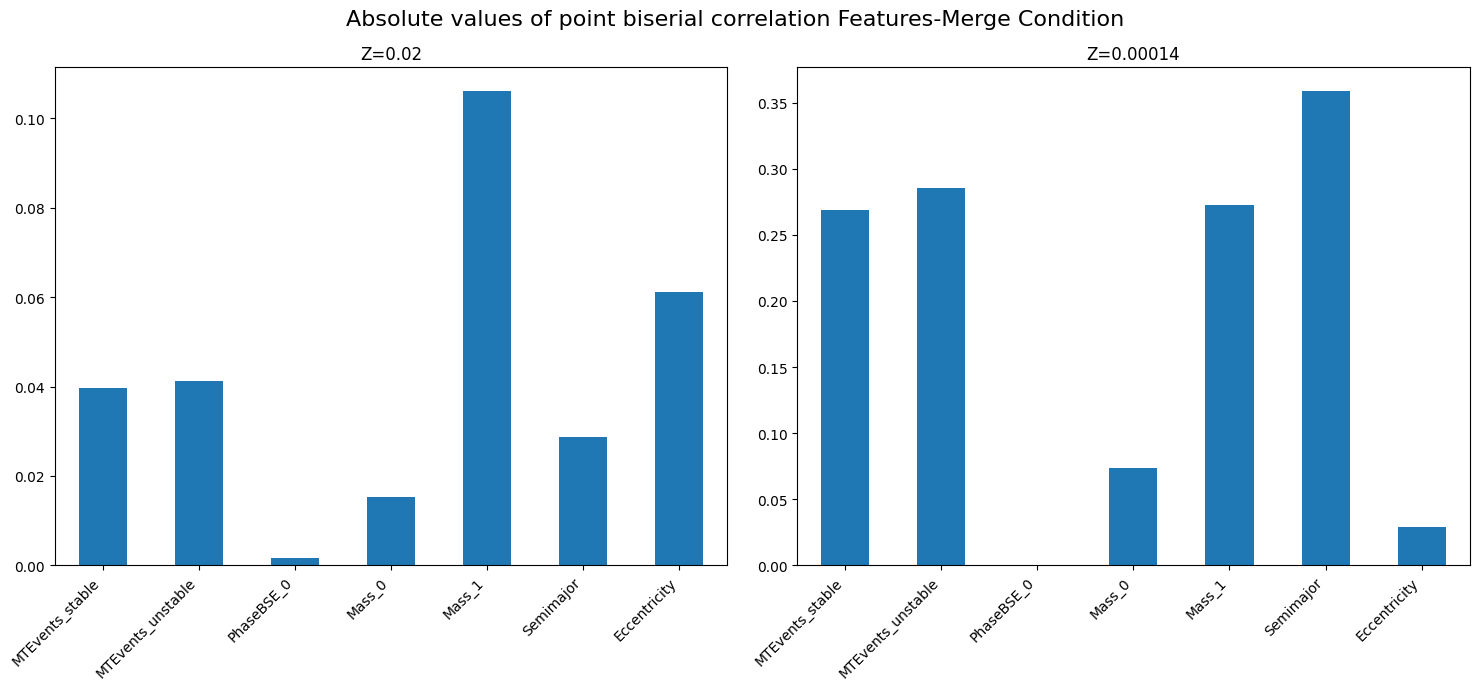

In [5]:
columns0 = data0.drop(columns=["Merge",'ID'])
correlation_dict0 = {}
for column in columns0:
    correlation = data0[column].corr(data0['Merge'])
    correlation_dict0[column] = correlation
correlation_df0=pd.DataFrame(correlation_dict0,index=['Correlation']).T

columns1 = data1.drop(columns=["Merge",'ID'])
correlation_dict1 = {}
for column in columns1:
    correlation = data1[column].corr(data1['Merge'])
    correlation_dict1[column] = correlation
correlation_df1=pd.DataFrame(correlation_dict1,index=['Correlation']).T

fig,axs=plt.subplots(1,2,figsize=(15,7))
abs(correlation_df0).plot.bar(ax=axs[0],legend=False)
abs(correlation_df1).plot.bar(ax=axs[1],legend=False)
axs[0].set_title('Z=0.02')
axs[1].set_title('Z=0.00014')

fig.suptitle('Absolute values of point biserial correlation Features-Merge Condition',fontsize=16)

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [6]:
def splitting_data(df, features, ratio=0.2):
    x = df[features]
    y = df.Merge
    N, L = x.shape[0], x.shape[1]
    N_train = int(ratio*N)
    x_train, y_train = x[:N_train], y[:N_train]
    x_test, y_test = x[N_train:], y[N_train:]
    return(x_train, y_train, x_test, y_test)

features = ['MTEvents_stable', 'MTEvents_unstable', 'Mass_BH', 'Mass_WR', 'Semimajor', 'Eccentricity', 'Mass_ratio']

# metallicity Z = 0.02
x0_train, y0_train, x0_test, y0_test = splitting_data(df0, features)

# metallicity Z = 0.00014
x1_train, y1_train, x1_test, y1_test = splitting_data(df1, features, ratio=0.5)

In [7]:
def grid_search(param_grid, x_train, y_train):
    RF = RandomForestClassifier(criterion='gini') 
    search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    results = search.fit(x_train, y_train)
    df_results = pd.DataFrame(results.cv_results_)
    df_results['mean_fit_time'] = results.cv_results_['mean_fit_time']
    df_results = df_results[['rank_test_score','mean_fit_time','std_fit_time','params',
                            'mean_test_score','std_test_score']].sort_values(by='mean_test_score', ascending=False)
    best_params = df_results['params'][0]
    return(df_results, best_params)

#parameters grid
grid = {'n_estimators': [30,60,80,150], 'max_depth': [3, 5, 7, 12], 'max_features': ['sqrt', 'log2', None]}

In [8]:
df0_results, best_params0 = grid_search(grid, x0_train, y0_train)

best_RF0 = RandomForestClassifier(**best_params0, criterion='gini', n_jobs=-1)
fit0 = best_RF0.fit(x0_train,y0_train)

print("Metallicity 0.02: Errors={:.2f}%, Accuracy={:.3f}".format(100*(1-best_RF0.score(x0_test, y0_test)), best_RF0.score(x0_test, y0_test)))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Metallicity 0.02: Errors=0.63%, Accuracy=0.994


In [9]:
df1_results, best_params1 = grid_search(grid, x1_train, y1_train)

best_RF1 = RandomForestClassifier(**best_params1, criterion='gini', n_jobs=-1)
fit1 = best_RF1.fit(x1_train,y1_train)

print("Metallicity 0.00014: Errors={:.2f}%, Accuracy={:.3f}".format(100*(1-best_RF1.score(x1_test, y1_test)), best_RF1.score(x1_test, y1_test)))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Metallicity 0.00014: Errors=5.66%, Accuracy=0.943


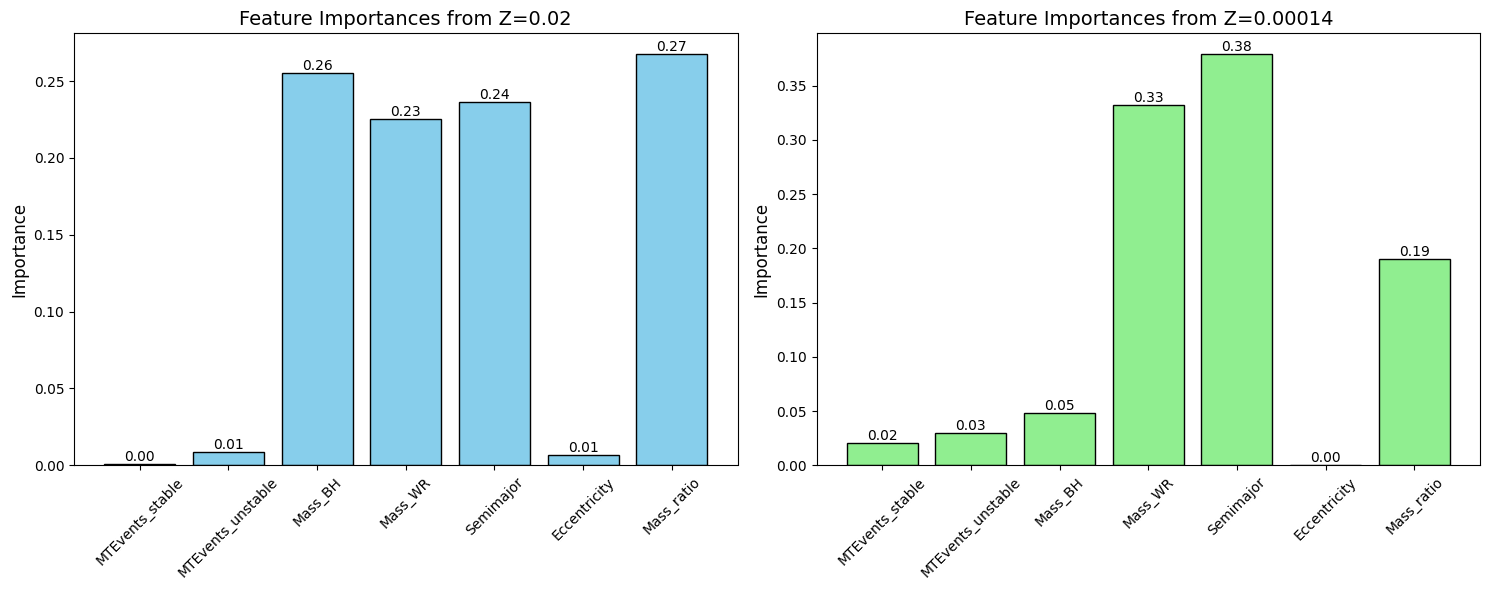

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))  

# Plot for the first random forest
bars0 = axes[0].bar(features, best_RF0.feature_importances_, color='skyblue', edgecolor='black')
axes[0].set_ylabel('Importance', fontsize=12)
axes[0].set_title('Feature Importances from Z=0.02', fontsize=14)
axes[0].tick_params(axis='x', labelsize=10, rotation=45)

for bar in bars0:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)


bars1 = axes[1].bar(features, best_RF1.feature_importances_, color='lightgreen', edgecolor='black')
axes[1].set_ylabel('Importance', fontsize=12)
axes[1].set_title('Feature Importances from Z=0.00014', fontsize=14)
axes[1].tick_params(axis='x', labelsize=10, rotation=45)

for bar in bars1:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  
plt.show()